# <center>**Classification of Unraveled Spirals**<center>

#### **Goal:** obtain a distance error between the misclassified hand drawn spirals and a LOBF ("ideal") spiral

Any functions / processes that require the use of tensorflow or keras need to be in this file. Other functions can be in a seperate python file. 

## **Process**
1. Import the skeletonized images
    - Convert to grayscale
    - Save all images in an array with the corresponding labels
2. Unravel all of the spirals
    - Normalize so they all have the same length
        - Do this by zero-padding?
3. Perform spline fitting
    - Subtract the spline from hand-drawing
    - This is the "deviation signal"
    - Convert to the frequency domain
        - Take the fft
        - Plot the magnitude of a couple of the spirals
5. Extract features
    - Need to decide what will be passed in as features for classification
        - variance, SNR, bandwidth, peaks, center freq?
6.  Run features through classifiers
    - RF, SVM, NB, KNN


In [107]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import warnings
import seaborn as sns

# import ML libraries
from sklearn import utils, svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from scipy.interpolate import UnivariateSpline 

# import files with certain functions
from code_files.archSpiral import * # functions of interest are 'unravelSpiral' and 'calcDist_to_center' 

warnings.filterwarnings('ignore')

## <center>Step 1: Import Skeletonized Images<center>

size of imgs array:  (382, 1000, 1000)
size of lbls array:  (382,)
Healthy:  206 , PD:  176


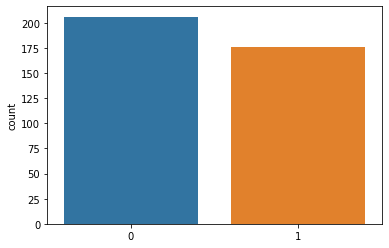

In [5]:
dir = os.getcwd()
folder_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/skel/spiral' #dir + '/datasets/folador_skeletonize/skeletons/spirals/'

imgs = [] # create empty array to store all the images
lbls = [] # create empty array to store the labels of the images
img_names = []
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    
    # convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img[img > 50] = 255
    img[img != 255] = 0


    # save image in 'imgs' array
    imgs.append(img)

    # save the labels in 'lbls' array
    # need to determine if it is healthy or parkinsons based on 'H' or 'P' being present in the file name
    if 'H' in img_name:
        lbls.append(0)
    else:
        lbls.append(1)

    img_names.append(img_name)

# shuffle the data
# imgs, lbls = utils.shuffle(imgs, lbls)

print("size of imgs array: ", np.shape(imgs))
print("size of lbls array: ", np.shape(lbls))

# plot the distribution of labls
sns.countplot(lbls)
print("Healthy: ", len(lbls)-np.count_nonzero(lbls), ", PD: ", np.count_nonzero(lbls))

## <center>Step 2: Unravel Spirals<center>

In [6]:
numImgs = len(imgs)
unraveledSpirals = [] # create empty array to store unraveled spirals

# iterate through all images and unravel
for i in range(numImgs):
    print(i, end='\r')
    center = unravelSpiral(imgs[i])
    unravelledImg = calcDist_to_center(imgs[i], center)
    unraveledSpirals.append(unravelledImg)

print(np.shape(unraveledSpirals))

# then need to normalize (do by zero padding)

(382,)


## <center>Step 3: Perform Spline Fitting<center>

In [18]:
fftSignals = [] 

# iterate through all the unravelled spirals
# fit a spline to each spiral individually
# subtract the spline from the hand-drawing
# store this difference signal in 'deviationSignals'
for i in range(numImgs):
    print(i, end='\r')
    # print(img_names[i])

    hand_drawing = unraveledSpirals[i][::2]
    numSamples = np.linspace(0, len(hand_drawing)-1, len(hand_drawing))    

    pad_width = 3750 - len(hand_drawing)
    pad_array = np.ones(pad_width).astype(np.int) 


    # calculate the line-of-best-fit (LOBF) or "spline"
    spl = UnivariateSpline(numSamples, hand_drawing, s=len(numSamples)*25, k=2)
    lobf = spl(numSamples)

    # plt.plot(hand_drawing)
    # plt.plot(lobf)
    # plt.show()

    # take the difference
    diff = hand_drawing - lobf
    
    # take the magnitude of the fft to convert to the frequency domain
    diff = (np.abs(np.fft.fftshift(np.fft.fft(diff)) / len(hand_drawing)))
    mean = np.mean(diff)
    diff = np.append(diff, (pad_array * mean))

    fftSignals.append(diff)
    
    xaxis = np.linspace(0, 3750-1, 3750)
    yaxis = np.append(hand_drawing, pad_array)
    lobf = np.append(lobf, pad_array)

    # fig, ax = plt.subplots(1,2,figsize=(20,5))
    # ax[0].plot(xaxis, yaxis, label="data", color='r')
    # ax[0].plot(xaxis, lobf, label="LOBF", color='b')
    # ax[1].plot(xaxis, diff)
    # plt.show()

## <center>Step 4: Extract Features<center>

In [19]:
# SNR, variance, BW, center freq, peaks

# obtain the magnitude
peaks = []
centers = []
var = []
snr = []
bw = []

for i in range(numImgs):
    sig = np.around(fftSignals[i], decimals=10) # round the values to 10 decimal places
    max = np.max(sig) # calculate the peak

    # find the "center freq" location
    peak_loc = np.argwhere(sig == max) 
    center_loc = peak_loc[0] + int((peak_loc[1] - peak_loc[0])/2)

    # calculate the variance
    sigVar = np.var(sig)

    # calculate SNR
    # seperate into noise part and signal part
    # calculate noise_floor threshold
    noise_floor = np.mean(sig)*2
    nf_approx = np.around(noise_floor,3)
    part_sig=[]
    part_noise=[]
    for samp in sig:
        if samp > nf_approx:
            part_sig.append(samp)
        else:
            part_noise.append(samp)
    # calc SNR
    m_sq = np.mean(part_sig)**2
    v    = np.var(part_noise)
    sigSNR = m_sq / v # mean of the signal squared / variance of the noise

    # avg = np.mean(sig)
    # std_dev = np.std(sig)
    # sigSNR = np.where(std_dev == 0, 0, avg/std_dev)

    # calculate the bandwidth
    # this will just be the total number of signal samples
    sigBW = len(part_sig)

    peaks.append(max)
    centers.append(center_loc)
    var.append(sigVar)
    snr.append(sigSNR)
    bw.append(sigBW)

In [45]:
# plot the histogram infromation of an images
# need to load in the original images (do this based on 'image_names' and just need to remove 'skel_' from out front)
# will need to set the right folder paths to load the folders
hist = []
thresh_val=[]
orig_img_folder_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/orig/spiral/'
for i in range(numImgs):
    print(i, end='\r')
    img_name = img_names[i].replace('skel_', '')
    
    if 'H' in img_name:
        group = 'healthy/'
    else:
        group = 'parkinson/'

    path = orig_img_folder_path + group + img_name
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # create the histogram
    thresh = np.mean(img)
    error = 255 - thresh
    thresh = np.around(thresh - error, 1)

    sigHist = 0
    sigThresh = thresh
    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            if img[x][y] < thresh:
                sigHist+=1

    hist.append(sigHist)
    thresh_val.append(sigThresh)

## <center>Step 5: Run Features Through Classifier<center>

In [82]:
# first put all the features in a dataframe

# try classifying with SVM
# https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python 

In [79]:
fft_features = {'labels':lbls,'peaks': peaks, 'centers':centers, 'variance':var, 'SNR':snr, 'BW':bw, 'hist': hist, 'thresh_val': thresh_val}
fft_df = pd.DataFrame(fft_features)
fft_df.head()

# save as csv 
# fft_df.to_csv('fft_df.csv', index=False)
# fft_raw = {'fft_data': fftSignals, 'labels':lbls}
# fft_raw = pd.DataFrame(fft_raw)
# fft_raw.head()


,labels,peaks,centers,variance,SNR,BW,hist,thresh_val
0,0,1.349553,[1164],0.006341,947.167450,130,4338,239.6
1,0,2.180498,[1130],0.006359,1103.208044,112,4412,238.7
2,0,2.167111,[1178],0.006311,569.276182,158,4973,236.0
3,0,1.763585,[1172],0.006276,678.878554,138,4598,235.8
4,0,1.586627,[1438],0.006309,830.932725,160,5060,235.4


In [149]:
x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1), fft_df.labels, test_size=0.20, random_state=24) #'peaks', 'variance', 'SNR', stratify=fft_df.labels

<AxesSubplot:xlabel='labels', ylabel='count'>

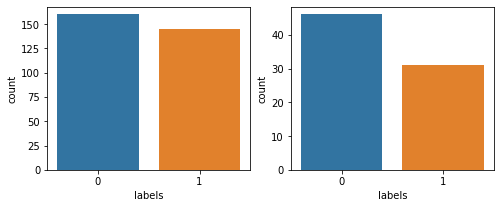

In [128]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
sns.countplot(y_train, ax=ax[0])
sns.countplot(y_test, ax=ax[1])

In [65]:
clf = svm.SVC(kernel='poly')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5844155844155844


In [150]:
# create SVM classifier
def SVM_classifier(train_data, train_labels, val_data, val_labels):

    #clf = svm.SVC(kernel='poly', degree=5)
    param_grid={'C':[100],'degree':[2,5,10],'kernel':['poly']}
    clf = svm.SVC(probability=True)
    svm_clf = GridSearchCV(clf, param_grid, cv=5)

    # train model
    svm_clf.fit(train_data, train_labels)
    # print(model.cv_results_.keys())
    # print(model.cv_results_)

    svm_clf.best_params_
    # print(svm_clf.best_params_)

    # predict the model
    pred = (svm_clf.predict(val_data))

    # calculate accuracy
    acc = round(metrics.accuracy_score(val_labels, pred),4)
    cfm = metrics.confusion_matrix(val_labels, pred)
    tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

    # print("The predicted data is: ", pred)
    # print("The actual data is: ", np.array(val_labels))
    print(f"The model is {acc*100}% accurate")

    return acc, tpr, tnr, cfm

svm_acc = []
svm_tpr = []
svm_tnr = []
svm_cfm = []

for ii in range(25):
    print('Random State: ', ii+1)
    rs = np.linspace(1, 25, 25).astype(np.int)
    x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1), fft_df.labels, test_size=0.20, random_state=rs[ii]) #'peaks', 'variance', 'SNR', stratify=fft_df.labels
    temp_acc, temp_tpr, temp_tnr, temp_cfm = SVM_classifier(x_train, y_train, x_test, y_test)
    svm_acc.append(temp_acc)
    svm_tpr.append(temp_tpr)
    svm_tnr.append(temp_tnr)
    svm_cfm.append(temp_cfm)


print("Random states: ", rs)
# print("Accuracy scores: ", svm_acc)
print("Average accuracy: ", np.mean(svm_acc))
print("Standard deviation: ", np.std(svm_acc))
print("Average TNR: ", np.mean(svm_tnr))
print("Average TPR: ", np.mean(svm_tpr))

Random State:  1
The model is 76.62% accurate
Random State:  2
The model is 66.23% accurate
Random State:  3
The model is 77.92% accurate
Random State:  4
The model is 71.43% accurate
Random State:  5
The model is 71.43% accurate
Random State:  6
The model is 62.339999999999996% accurate
Random State:  7
The model is 77.92% accurate
Random State:  8
The model is 71.43% accurate
Random State:  9
The model is 75.32% accurate
Random State:  10
The model is 79.22% accurate
Random State:  11
The model is 75.32% accurate
Random State:  12
The model is 77.92% accurate
Random State:  13
The model is 71.43% accurate
Random State:  14
The model is 75.32% accurate
Random State:  15
The model is 66.23% accurate
Random State:  16
The model is 70.13000000000001% accurate
Random State:  17
The model is 71.43% accurate
Random State:  18
The model is 74.03% accurate
Random State:  19
The model is 74.03% accurate
Random State:  20
The model is 62.339999999999996% accurate
Random State:  21
The model is 

In [151]:
print(svm_cfm)

[array([[35,  4],
       [14, 24]], dtype=int64), array([[33, 11],
       [15, 18]], dtype=int64), array([[39,  5],
       [12, 21]], dtype=int64), array([[34,  8],
       [14, 21]], dtype=int64), array([[29, 13],
       [ 9, 26]], dtype=int64), array([[30,  3],
       [26, 18]], dtype=int64), array([[36,  4],
       [13, 24]], dtype=int64), array([[34,  6],
       [16, 21]], dtype=int64), array([[35,  5],
       [14, 23]], dtype=int64), array([[40,  8],
       [ 8, 21]], dtype=int64), array([[33, 10],
       [ 9, 25]], dtype=int64), array([[37,  4],
       [13, 23]], dtype=int64), array([[37, 11],
       [11, 18]], dtype=int64), array([[34,  8],
       [11, 24]], dtype=int64), array([[32, 11],
       [15, 19]], dtype=int64), array([[34,  6],
       [17, 20]], dtype=int64), array([[40, 13],
       [ 9, 15]], dtype=int64), array([[30,  5],
       [15, 27]], dtype=int64), array([[33, 10],
       [10, 24]], dtype=int64), array([[25, 10],
       [19, 23]], dtype=int64), array([[28,  7],
  

<Figure size 432x288 with 0 Axes>

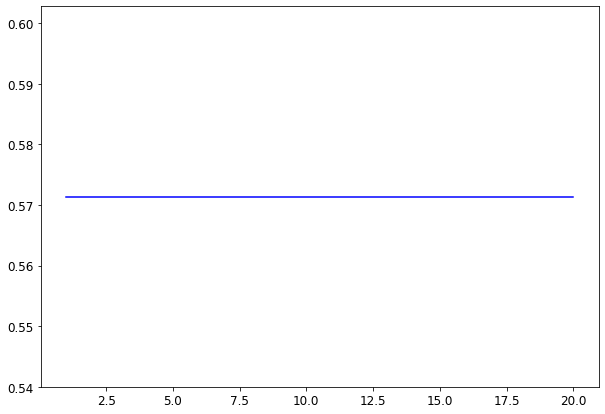

In [223]:
## Plotting
num_tests = np.linspace(1,len(svm_acc), len(svm_acc))

plt.figure(2)
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 12})

plt.plot(num_tests, svm_acc, 'b')
plt.show()

In [132]:
print('pause')

pause


### Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7272727272727273
